In [62]:
import numpy as np
from numpy.fft import ifftshift, ifft2, fftshift, fft2
from numpy import exp, pi, mean, var, std, abs, sin, cos

from matplotlib import pyplot as plt
%matplotlib inline 

from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase

from scipy.special import gamma

import pandas as pd

In [30]:
plt.rc('figure', figsize=[10,10])

In [3]:
''' Lin = 1e-3
Lout=100
fm = 5.92/Lin/(2*pi)
f0=1/Lout

deltax = 0.005
N=512
wvl=0.532e-6
Dz=50e3
ntrial=1
nscreen=50
kpow=22/6

Np=5

Rytov=0.2
''' 

' Lin = 1e-3\nLout=100\nfm = 5.92/Lin/(2*pi)\nf0=1/Lout\n\ndeltax = 0.005\nN=512\nwvl=0.532e-6\nDz=50e3\nntrial=1\nnscreen=50\nkpow=22/6\n\nNp=5\n\nRytov=0.2\n'

In [63]:
def subharmonics(N=512, Lout=10, Lin=1e-3, deltax=0.005, wvl=0.532e-6, Dz=50e3, nscreen=50, kpow=22/6, Rytov=0.2, Np=5):
    phz_lo = np.zeros([N, N])

    nn=np.arange(-np.floor(N/2), np.floor(N/2)) * deltax
    nx, ny = np.meshgrid(nn, nn)

    for p in range(Np):
        k=2*pi/wvl
        Cn2=Rytov/(1.2287 * k**(7/6) * Dz**(11/6))
        r0_Dz = (.423*k**2*Cn2*Dz)**(-3/5)
    
        deltaf=1/((Np**p)*(N*deltax))
    
        fx = np.linspace(-Np,1,Np, endpoint=True)
        fx, fy = np.meshgrid(fx, fx)
    
        fx=fx*deltaf
        fy=fy*deltaf
        fsq=fx**2+fy**2
    
        z=np.linspace(0,Dz,nscreen)
        deltaz=z[1]-z[0]
    
        r0 = (.423*(k**2)*Cn2*deltaz)**(-3/5)
        
        fm = 5.92/Lin/(2*pi)
        f0=1/Lout
        
        PSD_phi = 0.023 * r0**(-5/3) * exp(-(fsq/fm**2)) / (fsq + f0**2)**(kpow/2)
        PSD_phi[int(Np/2),int(Np/2)] = 0
    
        cnm = (np.random.randn(Np, Np) + 1j*np.random.randn(Np, Np) ) * np.sqrt(PSD_phi)*deltaf
        SH = np.zeros(N,N)
    
        for xi in range(Np):
            for yi in range(Np):
                SH = SH + cnm[xi][yi] * np.exp(1j*2*pi*(fx[xi][yi]*nx + fy[xi][yi]*ny))

        phz_lo = phz_lo + SH

    return np.real(phz_lo) - mean(np.real(phz_lo))

In [37]:
def ft_sh_phase_screen(N=512, Lout=10, Lin=1e-3, deltax=0.005, wvl=0.532e-6, Dz=50e3, nscreen=50, kpow=22/6, Rytov=0.2, Np=5):
    k=2*pi/wvl
    nn=np.arange(-np.floor(N/2), np.floor(N/2))
    nx, ny = np.meshgrid(nn, nn)
    nsq = nx**2 + ny**2
    z=np.linspace(0, Dz, nscreen)
    
    deltaz=z[1]-z[0]
    deltaf=1/(N*deltax)
    
    # 0.312 is weird
    #Cn2=Rytov/(0.312 * k**(7/6) * Dz**(11/6))
    Cn2=Rytov/(1.2287075122549518 * k**(7/6) * Dz**(11/6))
    r0 = (.423*k**2*Cn2*Dz)**(-3/5) #check
    
    fx=nx*deltaf
    fy=ny*deltaf
    fsq=fx**2+fy**2
    
    Uin=np.ones([N, N])
    g=Uin
    
    for idx in range(nscreen-1):
        #r0 = (.423*(k**2)*Cn2*deltaz)**(-3/5) # Constant Cn2
        
        fm = 5.92/Lin/(2*pi)
        f0=1/Lout
        
        PSD_phi = 0.023 * r0**(-5/3) * exp(-(fsq/fm**2)) / (fsq + f0**2)**(kpow/2)
        PSD_phi[int(N/2),int(N/2)] = 0
        
        cnm = (np.random.randn(N, N) + 1j*np.random.randn(N, N) ) * np.sqrt(PSD_phi)*deltaf
        phz_hi = np.real(ifftshift(ifft2(ifftshift(cnm)))*(N*1)**2)
        phz_lo = np.zeros([N, N])
        #phz_lo = subharmonics(Np, phz_hi)
        phz = phz_hi + phz_lo
        
        Q2 = exp(-1j*pi**2*2*deltaz/k*fsq)
        G= Q2*fftshift(fft2(fftshift(g)))*deltax**2
        g = ifftshift(ifft2(ifftshift(G)))*(N*deltaf)**2
        
        g = exp(1j*phz) * g

        #Asq=abs(g)**2
        #varI=var(Asq)
        #meanI=mean(Asq)
        #print("Rytov = {}\nCn2 = {}\nr0 = {}\nvarI = {}\nmeanI = {}".format(Rytov, Cn2, r0, varI, meanI))
        
    Uout = g
    
    Asq=abs(Uout)**2
    varI=var(Asq)
    meanI=mean(Asq)
    #print("Rytov = {}\nCn2 = {}\nr0 = {}\nvarI = {}\nmeanI = {}".format(Rytov, Cn2, r0, varI, meanI))
    
    return Uout

In [ ]:
ntrial = 20
vsmeans = []
vsstds = []
index = []
for r in range(1,250):#1):
    vsr = []
    Rytov = r/100
    index.append(Rytov)
    for n in range(ntrial):
        Uout = ft_sh_phase_screen(Rytov=Rytov)
        Asq=abs(Uout)**2
        varI=var(Asq)
        vsr.append(varI)
        print(r, n)
    m = mean(np.array(vsr))
    s = std(np.array(vsr))
    vsmeans.append(m)
    vsstds.append(s)


1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14


77 3
77 4
77 5
77 6
77 7
77 8
77 9
77 10
77 11
77 12
77 13
77 14
77 15
77 16
77 17
77 18
77 19
78 0
78 1
78 2
78 3
78 4
78 5
78 6
78 7
78 8
78 9
78 10
78 11
78 12
78 13
78 14
78 15
78 16
78 17
78 18
78 19
79 0
79 1
79 2
79 3
79 4
79 5
79 6
79 7
79 8
79 9
79 10
79 11
79 12
79 13
79 14
79 15
79 16
79 17
79 18
79 19
80 0
80 1
80 2
80 3
80 4
80 5
80 6
80 7
80 8
80 9
80 10
80 11
80 12
80 13
80 14
80 15
80 16
80 17
80 18
80 19
81 0
81 1
81 2
81 3
81 4
81 5
81 6
81 7
81 8
81 9
81 10
81 11
81 12
81 13
81 14
81 15
81 16
81 17
81 18
81 19
82 0
82 1
82 2
82 3
82 4
82 5
82 6
82 7
82 8
82 9
82 10
82 11
82 12
82 13
82 14
82 15
82 16
82 17
82 18
82 19
83 0
83 1
83 2
83 3
83 4
83 5
83 6
83 7
83 8
83 9
83 10
83 11
83 12
83 13
83 14
83 15
83 16
83 17
83 18
83 19
84 0
84 1
84 2
84 3
84 4
84 5
84 6
84 7
84 8
84 9
84 10
84 11
84 12
84 13
84 14
84 15
84 16
84 17
84 18
84 19
85 0
85 1
85 2
85 3
85 4
85 5
85 6
85 7
85 8
85 9
85 10
85 11
85 12
85 13
85 14
85 15
85 16
85 17
85 18
85 19
86 0
86 1
86 2
86 3
86 4


In [ ]:
#remember evaluate down separately

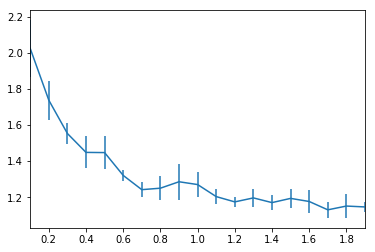

In [52]:
pd.Series(vsmeans, index=index).plot(yerr=vsstds)

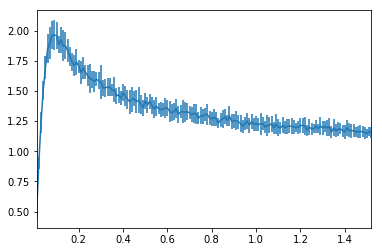

In [61]:
pd.Series(vsmeans, index=index[:152]).plot(yerr=vsstds)

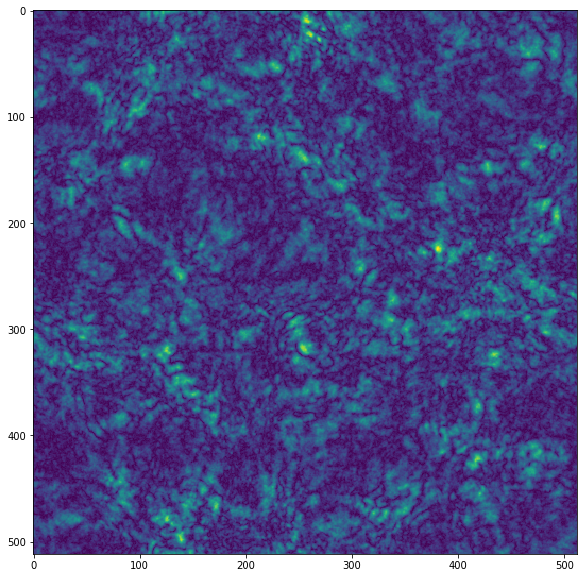

In [17]:
plt.imshow(abs(Uout))#.set_clim(0.0, 1)
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)
plt.show()

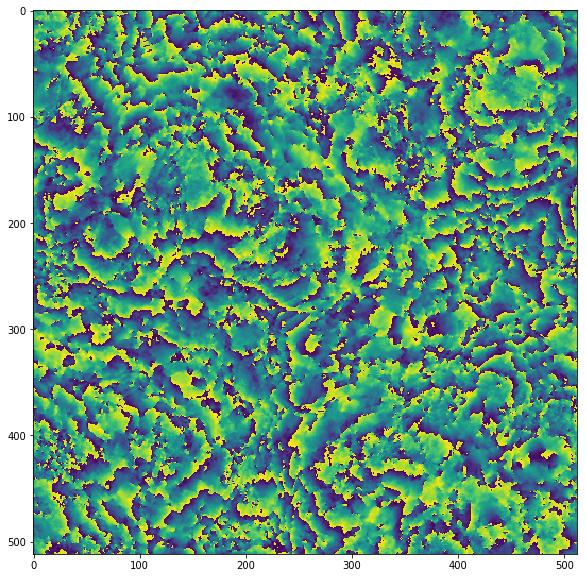

In [18]:
plt.imshow(np.angle(Uout))
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)
plt.show()

In [19]:
uw = np.unwrap(np.angle(Uout))

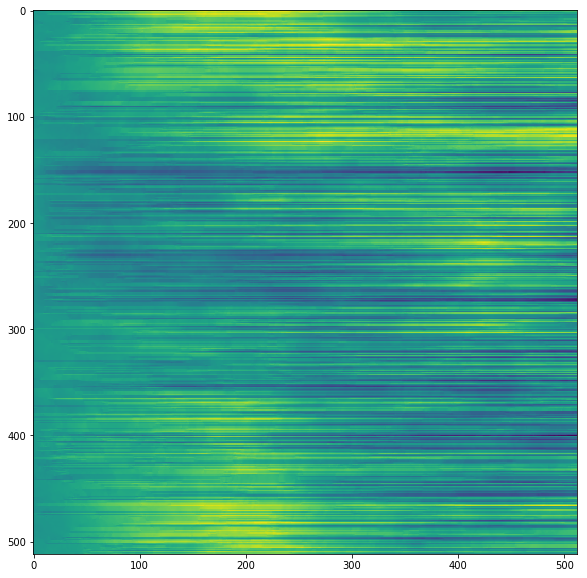

In [20]:
plt.imshow(uw)
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)

plt.show()

In [43]:
def text_phantom(text, size):
    # Availability is platform dependent
    font = 'arial'

    # Create font
    pil_font = ImageFont.truetype(font + ".ttf", size=len(text), encoding="unic")
    text_width, text_height = pil_font.getsize(text)

    # create a blank canvas with extra space between lines
    canvas = Image.new('RGB', [size, size], (255, 255, 255))

    # draw the text onto the canvas
    draw = ImageDraw.Draw(canvas)
    offset = ((size - text_width) // 2,
              (size - text_height) // 2)
    white = "#000000"
    draw.text(offset, text, font=pil_font, fill=white)

    # Convert the canvas into an array with values in [0, 1]
    return (255 - np.asarray(canvas)) / 255.0

In [44]:
from PIL import Image, ImageDraw, ImageFont

In [45]:
import matplotlib.pyplot as plt
plt.imshow(text_phantom('A', [100, 100]))
plt.imshow(text_phantom('Longer text', 100))

OSError: cannot open resource

In [9]:
for b in range(0):
    print(b)

In [53]:
def C(alpha):
    first = (2*gamma(1-alpha/2)*gamma(1+alpha))/(alpha*(1 + alpha/2))
    second = cos(pi*alpha/4)
    third = sin(pi * (alpha - 1)/2)
             
    return first*second*third

In [54]:
C(5/3)

1.2287075122549518

In [7]:
c = lambda alpha : (2*gamma(1-alpha/2)*gamma(1+alpha))/(alpha*(1 + alpha/2)) * (cos(pi*alpha/4)) * (sin(pi * (alpha - 1)/2))

In [57]:
for a in range(100,200):
    alpha = a/100
    print(alpha, C(alpha))

1.0 0.0
1.01 0.026063753589654997
1.02 0.05176365339221806
1.03 0.07711035988239796
1.04 0.1021140869883369
1.05 0.12678462254361408
1.06 0.15113134756316846
1.07 0.17516325441974576
1.08 0.1988889639917926
1.09 0.22231674184850675
1.1 0.24545451353296427
1.11 0.2683098789998439
1.12 0.2908901262602256
1.13 0.3132022442822123
1.14 0.33525293519269544
1.15 0.3570486258224209
1.16 0.3785954786335997
1.17 0.39989940206660535
1.18 0.42096606033982426
1.19 0.44180088273441104
1.2 0.4624090723935893
1.21 0.48279561466415116
1.22 0.502965285006001
1.23 0.5229226564938826
1.24 0.5426721069338704
1.25 0.5622178256157419
1.26 0.581563819721003
1.27 0.6007139204050715
1.28 0.6196717885709618
1.29 0.6384409203507267
1.3 0.6570246523098904
1.31 0.6754261663891745
1.32 0.69364849459693
1.33 0.7116945234648733
1.34 0.7295669982789531
1.35 0.7472685270964664
1.36 0.7648015845598645
1.37 0.782168515517076
1.38 0.7993715384575767
1.39 0.8164127487729024
1.4 0.8332941218497697
1.41 0.8500175160035173
1.4

In [7]:
print(Lin)

NameError: name 'Lin' is not defined

In [64]:
ntrial = 1
vsmeans = []
vsstds = []
index = []
for r in range(1,25):#1):
    vsr = []
    Rytov = r/10
    index.append(Rytov)
    for n in range(ntrial):
        Uout = ft_sh_phase_screen(Rytov=Rytov)
        Asq=abs(Uout)**2
        varI=var(Asq)
        vsr.append(varI)
    m = mean(np.array(vsr))
    s = std(np.array(vsr))
    vsmeans.append(m)
    vsstds.append(s)


1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0


In [98]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 28}

plt.rc('font', **font)

Text(0, 0.5, 'Intensity variance')

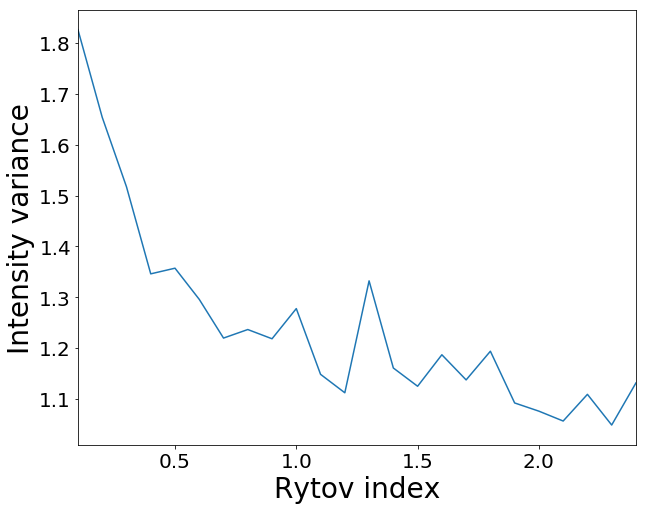

In [100]:
sp = pd.Series(vsmeans, index=index)
ax = sp.plot(yerr=vsstds, figsize=(10, 8))
ax.set_xlabel('Rytov index', )
ax.set_ylabel('Intensity variance')